# Derived Benthic Habitat of California's Nearshore Marine Protected Areas (MPAs)
MS 263 Final Project

Caroline Daley | Moss Landing Marine Laboratories 

May 2025

Please install [xDEM](https://xdem.readthedocs.io/en/stable/basic_examples/plot_terrain_attributes.html#sphx-glr-basic-examples-plot-terrain-attributes-py) to run the below code ([xDEM contributors 2024](https://doi.org/10.5281/zenodo.11492983)). 

In [58]:
import matplotlib.pyplot as plt
import xdem
import geopandas as gpd
import os
import rioxarray
import numpy as np
import xarray as xr
from rasterio.features import geometry_mask

Import the California coastline, nearshore network of MPAs, and CCFRP gridcells from the ['Shapefiles'](http://localhost:8888/lab/tree/Python%20Repository/Shapefiles) folder included in this repository to explore study area. 

In [63]:
grid_cells_shp = "C:\\Users\\FELAB\\Documents\\MS263\\Python Repository\\Shapefiles\\CCFRP_Grid_Cells_2021.shp"
grid_cells = gpd.read_file(grid_cells_shp)

ccfrp_mpas_shp = "C:\\Users\\FELAB\\Documents\\MS263\\Python Repository\\Shapefiles\\ccfrp_mpas.shp"
ccfrp_mpas = gpd.read_file(ccfrp_mpas_shp)

if grid_cells.crs != ccfrp_mpas.crs:
    ccfrp_mpas = ccfrp_mpas.to_crs(grid_cells.crs)

ca_coast_shp = "C:\\Users\\FELAB\\Documents\\MS263\\Python Repository\\Shapefiles\\CA_Shoreline.shp"
ca_coast = gpd.read_file(ca_coast_shp)

if grid_cells.crs != ca_coast.crs:
    ca_coast = ca_coast.to_crs(grid_cells.crs)

C:\Users\FELAB\AppData\Local\Temp\ipykernel_24332\1017267128.py:5: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  ccfrp_mpas.plot(ax=ax, column='NAME', color='blue', edgecolor='blue', linewidth=1)


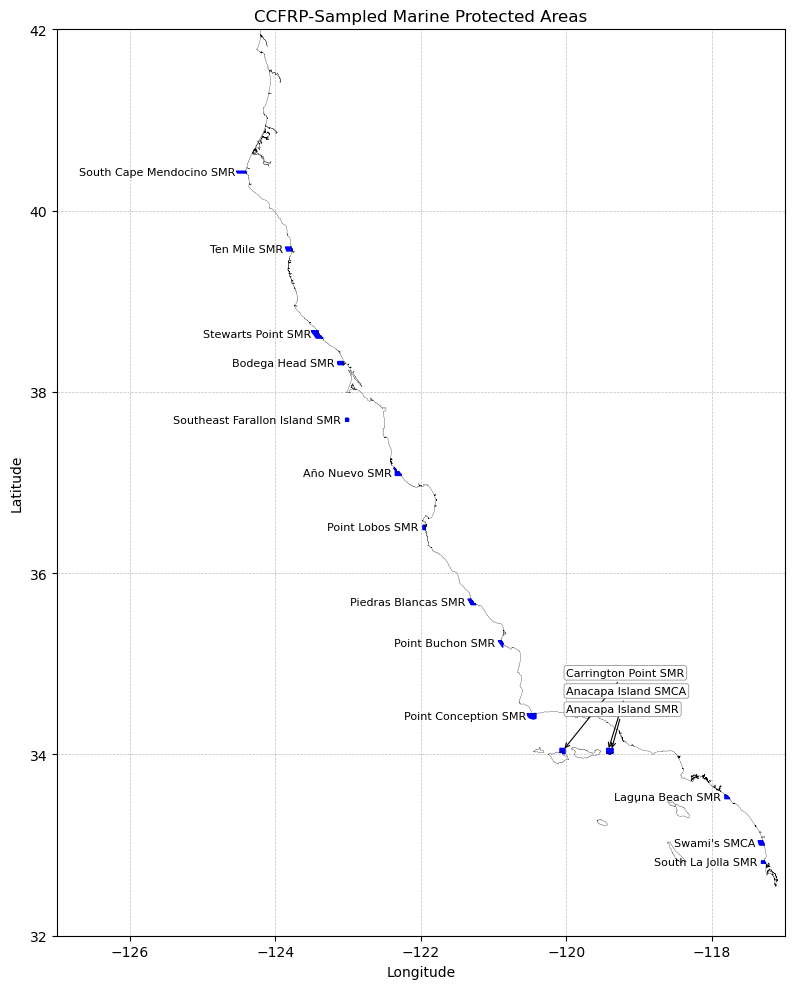

In [69]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the coastline and grid cells
ca_coast.plot(ax=ax, color='black', edgecolor='black', linewidth=0.2)
ccfrp_mpas.plot(ax=ax, column='NAME', color='blue', edgecolor='blue', linewidth=1)

# Label with arrows for specific crowded MPAs
label_overrides = {
    'Carrington Point SMR': (-120, 34.9),
    'Anacapa Island SMCA': (-120, 34.7),
    'Anacapa Island SMR': (-120, 34.5)
}

# The following labeling code was lifted from Chat GPT: 
# First, draw all the normal labels (skip the overridden ones)
for idx, row in ccfrp_mpas.iterrows():
    if row.geometry.is_empty:
        continue
    name = row['NAME']
    centroid = row.geometry.centroid
    if name not in label_overrides:
        ax.text(centroid.x - 0.08, centroid.y, str(name),
                fontsize=8, ha='right', va='center', color='black')

# Then add custom annotations with arrows for crowded labels
for name, (label_x, label_y) in label_overrides.items():
    row = ccfrp_mpas[ccfrp_mpas['NAME'] == name].iloc[0]
    centroid = row.geometry.centroid
    ax.annotate(name,
                xy=(centroid.x, centroid.y),           # Point to polygon
                xytext=(label_x, label_y),              # Place label here
                textcoords='data',
                fontsize=8,
                ha='left',
                va='center',
                arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', lw=0.5))

# Formatting
ax.set_title('CCFRP-Sampled Marine Protected Areas',)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.tick_params(labelsize=10)
ax.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--', alpha=0.5)
ax.set_ylim([32, 42])
ax.set_xlim([-127, -117])

plt.tight_layout()

output_dir = "C:\\Users\\FELAB\\Documents\\MS263\\Python Repository\\Figures"

output_path = os.path.join(output_dir, "CCFRP_MPA_map.png")
plt.savefig(output_path, dpi=300)


plt.show()


### Visualize & Explore Your Data

I import one of the digital elevation models (DEMs) to visualize some of the habitat metrics that I am going to explore in this project. Running this code also allows me to check that the xDEM package is running smoothly and that the outputs are what I might expect! The below code is adopted from the ['Terrain Attributes'](https://xdem.readthedocs.io/en/stable/basic_examples/plot_terrain_attributes.html#sphx-glr-basic-examples-plot-terrain-attributes-py) tutorial on the xDEM website. 

You will need to alter the specific path name for the raw DEM you are interested in examining to reflect where it is housed in your local computer. 

In [73]:
point_buchon_file = "C:\\Users\\FELAB\\Documents\\MS263\\Data\MASTER_DEM_TIFs\\Bathymetry_OffshorePointBuchon.tif"
point_buchon_DEM = xdem.DEM(pigeon_point_file)

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\FELAB\AppData\Local\Temp\ipykernel_24332\642050002.py:1: SyntaxWarning: invalid escape sequence '\M'
  point_buchon_file = "C:\\Users\\FELAB\\Documents\\MS263\\Data\MASTER_DEM_TIFs\\Bathymetry_OffshorePointBuchon.tif"


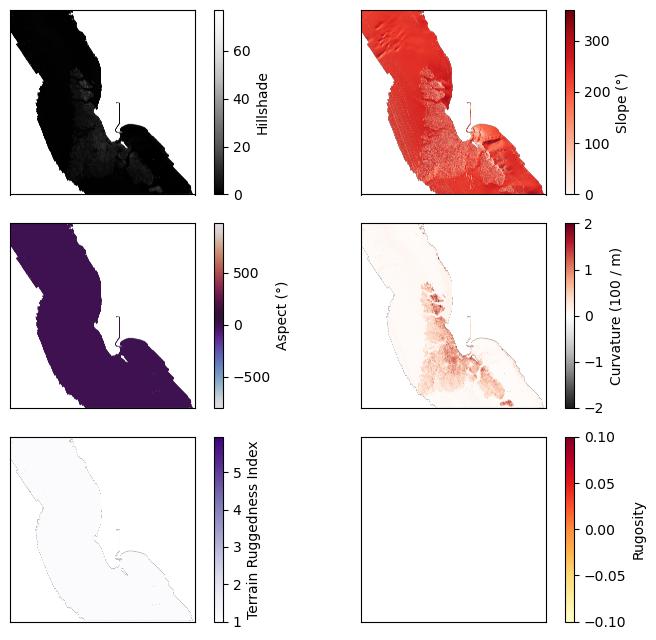

In [74]:
attributes = xdem.terrain.get_terrain_attribute(
    point_buchon_DEM.data,
    resolution=point_buchon_DEM.res,
    attribute=["slope", "aspect", "curvature", "terrain_ruggedness_index", "rugosity", "fractal_roughness"],
)

plt.figure(figsize=(8, 6.5))

plt_extent = [point_buchon_DEM.bounds.left, point_buchon_DEM.bounds.right, point_buchon_DEM.bounds.bottom, point_buchon_DEM.bounds.top]

cmaps = ["Greys_r", "Reds", "twilight", "RdGy_r", "Purples", "YlOrRd"]
labels = ["Hillshade", "Slope (°)", "Aspect (°)", "Curvature (100 / m)", "Terrain Ruggedness Index", "Rugosity"]
vlims = [(None, None) for i in range(6)]
vlims[3] = [-2, 2]

for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.imshow(attributes[i].squeeze(), cmap=cmaps[i], extent=plt_extent, vmin=vlims[i][0], vmax=vlims[i][1])
    cbar = plt.colorbar()
    cbar.set_label(labels[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

output_dir = "C:\\Users\\FELAB\\Documents\\MS263\\Python Repository\\Figures"

output_path = os.path.join(output_dir, "habitat_metrics_point_buchon.png")
plt.savefig(output_path, dpi=300)

plt.show()
plt.show()

### Import Raw DEMs 

Link to the folder where the raw DEM .tif files downloaded from the California Seafloor Mapping Program are housed. Make a list of the DEMs I will be working with. 

In [4]:
dem_folder = "C:\\Users\\FELAB\\Documents\\MS263\\Data\\MASTER_DEM_TIFs"
dem_list = []

for file_name in os.listdir(dem_folder):
    if file_name[-4:] == '.tif':
        dem_list.append(file_name)

dem_list.sort()

print(dem_list)

['Bathymetry_OffshoreBodegaHead.tif', 'Bathymetry_OffshoreCapeMendocino.tif', 'Bathymetry_OffshoreFortRoss.tif', 'Bathymetry_OffshorePigeonPoint.tif', 'Bathymetry_OffshorePointBuchon.tif', 'Bathymetry_OffshorePointConception.tif', 'Bathymetry_OffshoreSaltPoint.tif', 'Bathymetry_OffshoreSanGregorio.tif']


### Define Output Directory 

Define the folder to export derived habitat metrics. 

In [5]:
output_dir = "C:\\Users\\FELAB\\Documents\\MS263\\Python Repository\\xDEM_Habitat_Metrics"
os.makedirs(output_dir, exist_ok=True)

## Calculate Habitat Attributes Using xDEM

Define which habitat attributes I would like to calculate. 

In [6]:
habitat_attributes = ["slope", "aspect", "curvature", "terrain_ruggedness_index", "rugosity", "fractal_roughness"]

Calculate my specified habitat attributes for each of my DEMs of interest. The derived habitat attribtues will be exported into the above identified directory.

In [11]:
for dem_name in dem_list:
    dem_path = os.path.join(dem_folder, dem_name)
    print(f"Calculating habitat attributes for: {dem_name}")

    dem = xdem.DEM(dem_path)

    for attribute in habitat_attributes:
        data_np = xdem.terrain.get_terrain_attribute(
            dem.data,  
            resolution=dem.res,
            attribute=attribute
        )

        # Ensure data_np has the same dtype as the original DEM data
        data_np = data_np.astype(dem.data.dtype) 

        # Create a new DEM object to hold the computed attribute
        ddem = dem.copy() 

        # Update the data of the copy with the computed terrain attribute
        ddem.data = data_np 

        # Save the computed attribute directly to a file
        out_path = os.path.join(output_dir, f"{os.path.splitext(dem_name)[0]}_{attribute}.tif")
        ddem.save(out_path)

print("Calculation complete.")

Calculating habitat attributes for: Bathymetry_OffshoreBodegaHead.tif
Calculating habitat attributes for: Bathymetry_OffshoreCapeMendocino.tif
Calculating habitat attributes for: Bathymetry_OffshoreFortRoss.tif
Calculating habitat attributes for: Bathymetry_OffshorePigeonPoint.tif
Calculating habitat attributes for: Bathymetry_OffshorePointBuchon.tif
Calculating habitat attributes for: Bathymetry_OffshorePointConception.tif
Calculating habitat attributes for: Bathymetry_OffshoreSaltPoint.tif
Calculating habitat attributes for: Bathymetry_OffshoreSanGregorio.tif
Calculation complete.


### Sanity Check
Check out the slope product that you generated! 


C:\Users\FELAB\miniconda3\Lib\site-packages\matplotlib\colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


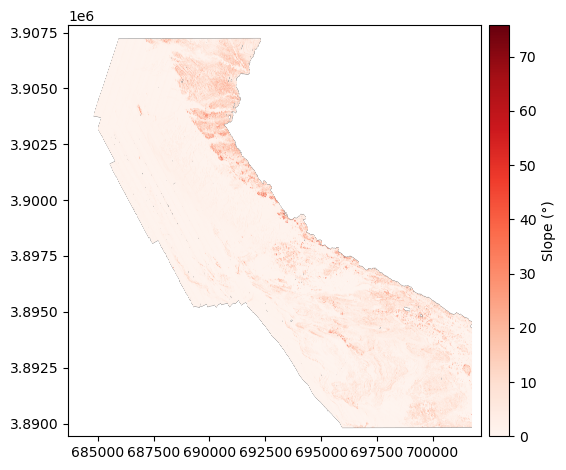

In [71]:
bodega_head_slope_tif = "C:\\Users\\FELAB\\Documents\\MS263\\Python Repository\\xDEM_Habitat_Metrics\\Bathymetry_OffshorePointBuchon_slope.tif"
bodega_head_slope = xdem.DEM(bodega_head_slope_tif)

bodega_head_slope.plot(cmap="Reds", cbar_title="Slope (°)")